In [1]:
from pathlib import Path
import argparse
import itertools
from PIL import Image

import random

from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.io import read_image
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm

from process_model_weights import *
from celeb_backbone import *

In [2]:
def epoch_loader(epoch):
    filepath = Path("/models/fine_tune/epoch{epoch}.pth")
    model = vgg_face_dag(weights_path=filepath)
    return model

def transform_image(img_path):
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        #transforms.Normalize(mean=[129.186279296875, 104.76238250732422, 93.59396362304688], std=[1, 1, 1]) 
    ])

    image = Image.open(img_path)
    image = transform(image).squeeze(0)
    
    return image 


def transform_image_forward(img_path):
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        #transforms.Normalize(mean=[129.186279296875, 104.76238250732422, 93.59396362304688], std=[1, 1, 1]) 
    ])

    image = Image.open(img_path)
    image = transform(image).unsqueeze(0)
    
    return image 


/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)
Clipping input data to t

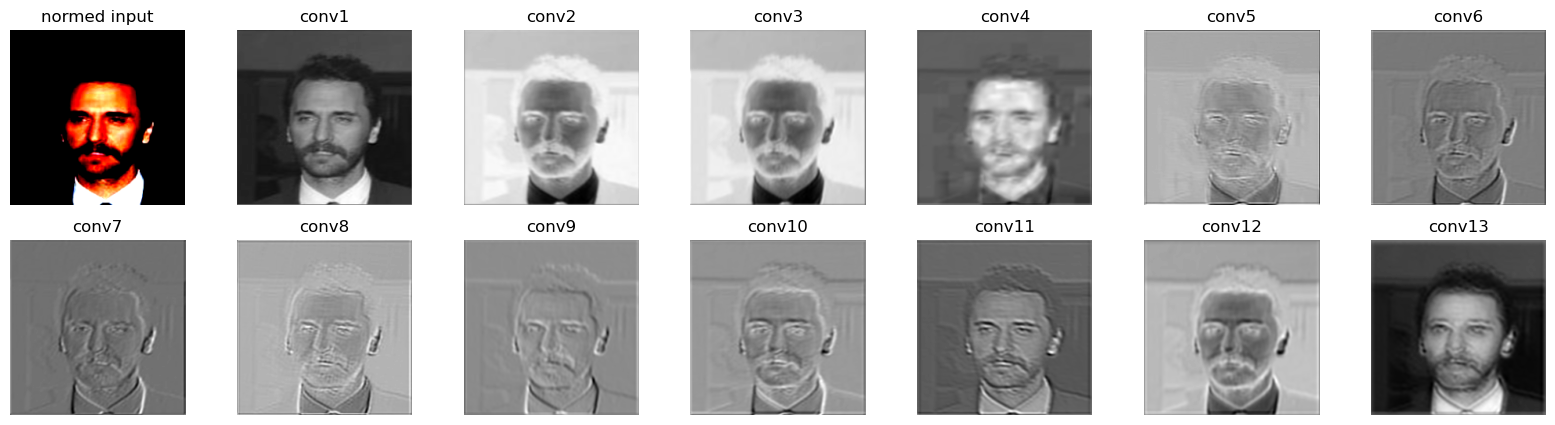

In [3]:
img_path = "test_images/101266.jpg"
image = transform_image(img_path)

pretrained_weights = Path("vggface.pth")
model = vgg_face_dag(weights_path=pretrained_weights)

model_weights = []
conv_layers = []

model_children = list(model.children())
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])

results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results


fig, axes = plt.subplots(2,7, figsize=(20, 5))
ax_list = axes.flatten()

ax = ax_list[0]
ax.imshow(image.detach().numpy().transpose(1, 2, 0))
ax.set_title("normed input")

ax.axis('off')

for i in range(1, len(outputs) + 1):
    ax = ax_list[i]
    
    t = outputs[i - 1]
    
    feature_map = t[-1, :, :].detach().cpu().numpy()

    ax.imshow(feature_map, cmap="gray")
    ax.set_title(f"conv{i}")
    ax.axis('off') 

# Process embeddings

In [2]:
sequence_length = 5

files = ["002514.jpg",
 "039593.jpg",
 "094741.jpg",
 "152801.jpg",
 "126154.jpg",
 "034026.jpg",
 "012857.jpg",
 "016242.jpg",
 "041553.jpg",
 "068982.jpg",]

path = Path(f"celebA_embeddings/seq{sequence_length}")

In [6]:
sequences, labels, positions, ns = generate_sequences(files, sequence_length=5)

In [9]:
i = 7888
print(sequences[i])
print(labels[i])
print(positions[i])
print(ns[i])

print(Counter(np.array(sequences).flatten()))

['012857.jpg', '039593.jpg', '041553.jpg', '039593.jpg', '068982.jpg']
[0. 0. 0. 1. 0.]
(1, 3)
2
Counter({'002514.jpg': 25200, '039593.jpg': 25200, '094741.jpg': 25200, '152801.jpg': 25200, '126154.jpg': 25200, '034026.jpg': 25200, '012857.jpg': 25200, '016242.jpg': 25200, '041553.jpg': 25200, '068982.jpg': 25200})


In [58]:
sequence_length = 5
sequences, labels, positions, ns = generate_sequences(files, sequence_length=5)

save_dir="celebA_embeddings"
path = Path(f"{save_dir}/seq{sequence_length}")
backbone = VGGEmbeds()

checkpoint = 1

sequences, labels, positions, ns = generate_sequences(files, sequence_length=5)

filenames = [f"{i:06d}.pt" for i in range(checkpoint, len(labels) + 1)]

if checkpoint > 1:
    sequences = sequences[checkpoint-1:]
    labels = labels[checkpoint-1:]
    positions = positions[checkpoint-1:]
    ns = ns[checkpoint-1:]


assert len(filenames) == len(sequences) == len(labels)

for s, f, l, p, n in zip(sequences, filenames, labels, positions, ns):

    #print(f)


    tensor =  torch.stack([backbone.embedding(file) for file in s])

    saver = {"sequence": tensor, 
             "label": l, 
             "positions": p, 
             "n-distance": n}

    torch.save(saver, path / f)
    

/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


KeyboardInterrupt: 

In [7]:
### longer sequences -- subsample 


In [9]:
values = ns
num_samples = 100

def uniform_random_samples(values, num_samples, seed=88):

    random.seed(seed)
    
    value_indices = defaultdict(list)
    for index, value in enumerate(values):
        value_indices[value].append(index)

    unique_values = list(value_indices.keys())
    num_unique_values = len(unique_values)

    samples = []
    for _ in range(num_samples):
        # If we've used all unique values, reset the list
        if not unique_values:
            unique_values = list(value_indices.keys())
        
        # Randomly select a value
        selected_value = random.choice(unique_values)
        unique_values.remove(selected_value)
        
        # Randomly select an index from the chosen value's indices
        selected_index = random.choice(value_indices[selected_value])
        samples.append(selected_index)
    
    return samples


### generate longer sequences, subsample

# 6

In [47]:
sequence_length = 6
sequences, labels, positions, ns = generate_sequences(files, sequence_length=sequence_length)

sample_size = 50000

samples = uniform_random_samples(ns, sample_size)
print(Counter(np.array(ns)[samples]))

sequences = np.array(sequences)[samples]
labels = np.array(labels)[samples]
positions = np.array(positions)[samples]
ns = np.array(ns)[samples]

Counter({4: 10000, 3: 10000, 5: 10000, 1: 10000, 2: 10000})


In [48]:

save_dir = "celebA_embeddings"
path = Path(f"{save_dir}/seq{sequence_length}")
path.mkdir(exist_ok=True, parents=True)
print(path)

backbone = VGGEmbeds()

checkpoint = 1
filenames = [f"{i:06d}.pt" for i in range(checkpoint, len(labels) + 1)]
print(f"Len filenames: {len(filenames)}")

if checkpoint > 1:
    sequences = sequences[checkpoint-1:]
    labels = labels[checkpoint-1:]
    positions = positions[checkpoint-1:]
    ns = ns[checkpoint-1:]

assert len(filenames) == len(sequences) == len(labels)

dataset = EmbeddingDataset(sequences, labels, positions, ns)
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=True, collate_fn=custom_collate)

# Process data in batches
with torch.no_grad():  # Disable gradient calculation
    for i, (batch_sequences, batch_labels, batch_positions, batch_ns) in enumerate(tqdm(dataloader)):
        batch_tensors = []
        for sequence in batch_sequences:
            sequence_tensors = []
            for file in sequence:
        
                sequence_tensors.append(backbone.embedding(file))

            batch_tensors.append(torch.stack(sequence_tensors))
        
        batch_tensor = torch.stack(batch_tensors)
        
        for j, tensor in enumerate(batch_tensor):
            idx = i * len(batch_sequences) + j
            saver = {
                "sequence": tensor.cpu(),  # Move back to CPU for saving
                "label": batch_labels[j],
                "positions": batch_positions[j],
                "n-distance": batch_ns[j]
            }
            torch.save(saver, path / filenames[idx])

celebA_embeddings/seq6


/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Len filenames: 50000


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [15:29<00:00,  1.68it/s]


# 7

In [49]:
sequence_length = 7
sequences, labels, positions, ns = generate_sequences(files, sequence_length=sequence_length)

sample_size = 50000

samples = uniform_random_samples(ns, sample_size)
print(Counter(np.array(ns)[samples]))

sequences = np.array(sequences)[samples]
labels = np.array(labels)[samples]
positions = np.array(positions)[samples]
ns = np.array(ns)[samples]

Counter({3: 8334, 6: 8334, 4: 8333, 1: 8333, 5: 8333, 2: 8333})


In [50]:

save_dir = "celebA_embeddings"
path = Path(f"{save_dir}/seq{sequence_length}")
path.mkdir(exist_ok=True, parents=True)
print(path)

backbone = VGGEmbeds()

checkpoint = 1
filenames = [f"{i:06d}.pt" for i in range(checkpoint, len(labels) + 1)]
print(f"Len filenames: {len(filenames)}")

if checkpoint > 1:
    sequences = sequences[checkpoint-1:]
    labels = labels[checkpoint-1:]
    positions = positions[checkpoint-1:]
    ns = ns[checkpoint-1:]

assert len(filenames) == len(sequences) == len(labels)

dataset = EmbeddingDataset(sequences, labels, positions, ns)
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=True, collate_fn=custom_collate)

# Process data in batches
with torch.no_grad():  # Disable gradient calculation
    for i, (batch_sequences, batch_labels, batch_positions, batch_ns) in enumerate(tqdm(dataloader)):
        batch_tensors = []
        for sequence in batch_sequences:
            sequence_tensors = []
            for file in sequence:
        
                sequence_tensors.append(backbone.embedding(file))

            batch_tensors.append(torch.stack(sequence_tensors))
        
        batch_tensor = torch.stack(batch_tensors)
        
        for j, tensor in enumerate(batch_tensor):
            idx = i * len(batch_sequences) + j
            saver = {
                "sequence": tensor.cpu(),  # Move back to CPU for saving
                "label": batch_labels[j],
                "positions": batch_positions[j],
                "n-distance": batch_ns[j]
            }
            torch.save(saver, path / filenames[idx])

celebA_embeddings/seq7


/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Len filenames: 50000


100%|██████████| 1563/1563 [17:48<00:00,  1.46it/s]


# 8

In [51]:
sequence_length = 8
sequences, labels, positions, ns = generate_sequences(files, sequence_length=sequence_length)

sample_size = 50000

samples = uniform_random_samples(ns, sample_size)
print(Counter(np.array(ns)[samples]))

sequences = np.array(sequences)[samples]
labels = np.array(labels)[samples]
positions = np.array(positions)[samples]
ns = np.array(ns)[samples]

Counter({4: 7143, 3: 7143, 6: 7143, 2: 7143, 5: 7143, 7: 7143, 1: 7142})


In [52]:

save_dir = "celebA_embeddings"
path = Path(f"{save_dir}/seq{sequence_length}")
path.mkdir(exist_ok=True, parents=True)
print(path)

backbone = VGGEmbeds()

checkpoint = 1
filenames = [f"{i:06d}.pt" for i in range(checkpoint, len(labels) + 1)]
print(f"Len filenames: {len(filenames)}")

if checkpoint > 1:
    sequences = sequences[checkpoint-1:]
    labels = labels[checkpoint-1:]
    positions = positions[checkpoint-1:]
    ns = ns[checkpoint-1:]

assert len(filenames) == len(sequences) == len(labels)

dataset = EmbeddingDataset(sequences, labels, positions, ns)
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=True, collate_fn=custom_collate)

# Process data in batches
with torch.no_grad():  # Disable gradient calculation
    for i, (batch_sequences, batch_labels, batch_positions, batch_ns) in enumerate(tqdm(dataloader)):
        batch_tensors = []
        for sequence in batch_sequences:
            sequence_tensors = []
            for file in sequence:
        
                sequence_tensors.append(backbone.embedding(file))

            batch_tensors.append(torch.stack(sequence_tensors))
        
        batch_tensor = torch.stack(batch_tensors)
        
        for j, tensor in enumerate(batch_tensor):
            idx = i * len(batch_sequences) + j
            saver = {
                "sequence": tensor.cpu(),  # Move back to CPU for saving
                "label": batch_labels[j],
                "positions": batch_positions[j],
                "n-distance": batch_ns[j]
            }
            torch.save(saver, path / filenames[idx])

celebA_embeddings/seq8


/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Len filenames: 50000


100%|██████████| 1563/1563 [20:30<00:00,  1.27it/s]


# 10

In [55]:
sequence_length = 10
sequences, labels, positions, ns = generate_sequences(files, sequence_length=sequence_length)

sample_size = 50000

samples = uniform_random_samples(ns, sample_size)
print(Counter(np.array(ns)[samples]))

sequences = np.array(sequences)[samples]
labels = np.array(labels)[samples]
positions = np.array(positions)[samples]
ns = np.array(ns)[samples]

Counter({6: 5556, 5: 5556, 9: 5556, 1: 5556, 2: 5556, 7: 5555, 8: 5555, 3: 5555, 4: 5555})


In [56]:

save_dir = "celebA_embeddings"
path = Path(f"{save_dir}/seq{sequence_length}")
path.mkdir(exist_ok=True, parents=True)
print(path)

backbone = VGGEmbeds()

checkpoint = 1
filenames = [f"{i:06d}.pt" for i in range(checkpoint, len(labels) + 1)]
print(f"Len filenames: {len(filenames)}")

if checkpoint > 1:
    sequences = sequences[checkpoint-1:]
    labels = labels[checkpoint-1:]
    positions = positions[checkpoint-1:]
    ns = ns[checkpoint-1:]

assert len(filenames) == len(sequences) == len(labels)

dataset = EmbeddingDataset(sequences, labels, positions, ns)
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, pin_memory=True, collate_fn=custom_collate)

# Process data in batches
with torch.no_grad():  # Disable gradient calculation
    for i, (batch_sequences, batch_labels, batch_positions, batch_ns) in enumerate(tqdm(dataloader)):
        batch_tensors = []
        for sequence in batch_sequences:
            sequence_tensors = []
            for file in sequence:
        
                sequence_tensors.append(backbone.embedding(file))

            batch_tensors.append(torch.stack(sequence_tensors))
        
        batch_tensor = torch.stack(batch_tensors)
        
        for j, tensor in enumerate(batch_tensor):
            idx = i * len(batch_sequences) + j
            saver = {
                "sequence": tensor.cpu(),  # Move back to CPU for saving
                "label": batch_labels[j],
                "positions": batch_positions[j],
                "n-distance": batch_ns[j]
            }
            torch.save(saver, path / filenames[idx])

celebA_embeddings/seq10


/home/alanadarcher/bmm/bmm-project/process_model_weights.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path)


Len filenames: 50000


100%|██████████| 1563/1563 [25:45<00:00,  1.01it/s]


In [66]:
dataset[0]

(array(['016242.jpg', '002514.jpg', '012857.jpg', '002514.jpg',
        '152801.jpg', '041553.jpg', '034026.jpg'], dtype='<U10'),
 array([0., 0., 0., 1., 0., 0., 0.]),
 array([1, 3]),
 2)

In [54]:
path = "celebA_embeddings/seq8/002000.pt"
test = torch.load(path, weights_only=False)

print(sum(test["sequence"][test["positions"][0]][0] - test["sequence"][test["positions"][1]][0]))

tensor(0.)
